In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil

plt.rcParams['text.usetex'] = False

from paths import DATA_DIR
from paths import PLOTS_DIR

df_timeloop = pd.read_csv(DATA_DIR / "timeloop_gemm_16k.csv")
df_timeloop_hint = pd.read_csv(DATA_DIR / "timeloop_gemm_16k_hint.csv")
df_sunstone = pd.read_csv(DATA_DIR / "sunstone_gemm_16k.csv")
df_zigzag = pd.read_csv(DATA_DIR / "zigzag_gemm_16k.csv")
df_zigzag_bypass_hint = pd.read_csv(DATA_DIR / "zigzag_gemm_16k_no_llb.csv")
df_ffm = pd.read_csv(DATA_DIR / "ffm_gemm_16k.csv")

DATAFRAMES = [df_timeloop, df_timeloop_hint, df_sunstone, df_zigzag, df_ffm]

for df in DATAFRAMES:
    if "edp" in df:
        continue
    df["edp"] = df["energy"]*df["latency"]
    df["total_time"] = df["mapper_time"]

for df in [df_timeloop, df_timeloop_hint]:
    df["total_time"] = df["mapper_time"]*df["threads"]

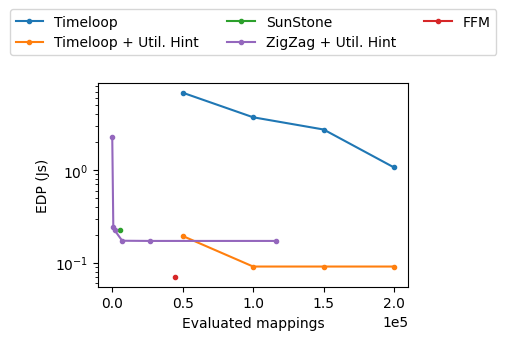

In [33]:
LABELS = ["EDP (Js)"]
COLUMNS = ["edp", "latency", "energy"]

num_axes = len(list(zip(LABELS, COLUMNS)))

MARKERS = ['.']*len(DATAFRAMES)
COLORS = ['C0', 'C1', 'C2', 'C4', 'C3']
NAMES = ["Timeloop", "Timeloop + Util. Hint", "SunStone", "ZigZag + Util. Hint", "FFM"]

fig, axes = plt.subplots(num_axes, 1, sharex=True, figsize=(4, 4*0.66*num_axes))
if isinstance(axes, plt.Axes):
    axes = [axes]

for i, (label, column) in enumerate(zip(LABELS, COLUMNS)):
    ax=axes[i]
    ax.set_ylabel(label)
    for df, marker, name, color in zip(DATAFRAMES, MARKERS, NAMES, COLORS):
        if "evaluations" not in df:
            continue
        df.plot(x="evaluations", y=column, ax=ax, marker=marker, label=name, color=color)
    ax.set_yscale("log")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))
    if i > 0:
        ax.get_legend().remove()
    else:
        ax.legend(ncols=ceil(len(DATAFRAMES)/2), bbox_to_anchor=(0.5,1.4), loc="upper center")

ax.set_xlabel('Evaluated mappings')
fig.savefig(PLOTS_DIR / "gemm_16k_edp_vs_evals.png", dpi=400, bbox_inches="tight")

In [34]:
def get_rows_with_closest_evaluations(df, evaluations):
    """
    Returns two rows (x, y) where
    x is the row with closest `x["evaluations"] <= evaluations`
    and y is the row with closest `y["evaluations"] >= evaluations.`
    """
    less_than_df = df[df["evaluations"] <= evaluations]
    if len(less_than_df) == 0:
        x = None
    else:
        x = less_than_df.iloc[less_than_df["evaluations"].argmax()]
    greater_than_df = df[df["evaluations"] >= evaluations]
    if len(greater_than_df) == 0:
        y = None
    else:
        y = greater_than_df.iloc[greater_than_df["evaluations"].argmin()]
    return x, y

def get_edp_with_closest_evaluations(df, evaluations):
    x, y = get_rows_with_closest_evaluations(df, 43000)
    if x is None:
        return y["edp"]
    elif y is None:
        return x["edp"]
    else:
        # Interpolate linearly between x and y
        slope = (y["edp"] - x["edp"])/(y["evaluations"] - x["evaluations"])
        return x["edp"] + slope*(evaluations - x["evaluations"])


/tmp/ipykernel_937/475512978.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(NAMES_SHORT, rotation=15)


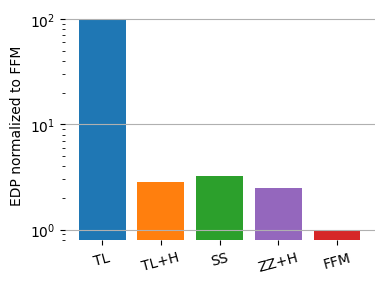

In [36]:
import seaborn as sns

fastfusion_evals = df_ffm.iloc[df_ffm["edp"].argmin()]["evaluations"]
fastfusion_edp = df_ffm["edp"].min()

EDPS = []
for df in DATAFRAMES:
    EDPS.append(get_edp_with_closest_evaluations(df, fastfusion_evals)/fastfusion_edp)

NAMES_SHORT = ["TL", "TL+H", "SS", "ZZ+H", "FFM"]
# COLORS      = ['C0', 'C1', 'C2', 'C3',   'C4']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.bar(NAMES_SHORT, EDPS, color=COLORS)
ax.set_yscale("log")
ax.set_xticklabels(NAMES_SHORT, rotation=15)
ax.grid(axis='y')
ax.set_ylabel("EDP normalized to FFM")
sns.despine(ax=ax, left=True, bottom=True)

fig.savefig(PLOTS_DIR / "gemm_16k_edp.png", dpi=400, bbox_inches="tight")

/tmp/ipykernel_937/493416638.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(NAMES_SHORT, rotation=15)
/tmp/ipykernel_937/493416638.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(NAMES_SHORT, rotation=15)


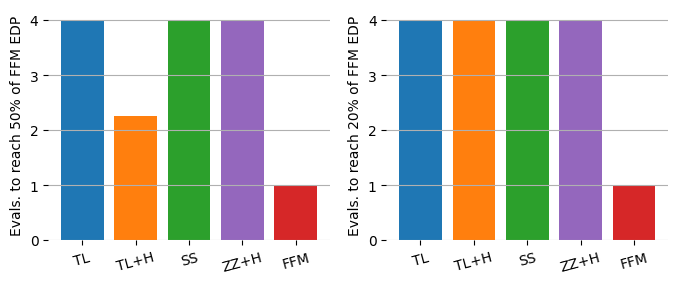

In [44]:
def get_rows_with_edp(df, edp):
    """
    Returns rows where `x["edp"]` is <= `edp` or None if no such row exists.
    """
    df_less_than = df[df["edp"] <= edp]
    if len(df_less_than) == 0:
        return None
    else:
        return df_less_than.iloc[df_less_than["edp"].argmax()]

MAX_EVALS_IN_PLOT = fastfusion_evals*4

DISTANCES = [50, 20]

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for ax, distance in zip(axes, DISTANCES):
    evaluations = []
    for df in DATAFRAMES:
        row = get_rows_with_edp(df, (100+distance)/100*fastfusion_edp)
        if row is None:
            evaluations.append(MAX_EVALS_IN_PLOT/fastfusion_evals)
        else:
            evaluations.append(row["evaluations"]/fastfusion_evals)

    ax.bar(NAMES_SHORT, evaluations, color=COLORS)
    ax.set_xticklabels(NAMES_SHORT, rotation=15)
    ax.grid(axis='y')
    ax.set_ylabel(f"Evals. to reach {distance}% of FFM EDP")
    sns.despine(ax=ax, left=True, bottom=True)

fig.savefig(PLOTS_DIR / "gemm_16k_evals.png", dpi=400, bbox_inches="tight")